# EDA Model Training vs Real Distributions

## Constant Fluctuations
The NN model was trained assuming that the following input values were always constant:
* `distgen:total_charge:value`
* `L0A_scale:voltage`
* `L0B_scale:voltage`

In order to validate whether that's true and whether their instability during live production will disrupt training, we want to see how much these values fluctuate in real machine behaviour over a day.

In [69]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [78]:
time_series = pd.read_pickle('data/full_2022-09-23_12_18_58-07_00__2022-09-23_23_03_01-07_00.pkl')
print(time_series.columns)

Index(['index', 'timestamp', 'SOLN:IN20:121:BACT', 'QUAD:IN20:121:BACT',
       'QUAD:IN20:122:BACT', 'QUAD:IN20:361:BACT', 'QUAD:IN20:371:BACT',
       'QUAD:IN20:425:BACT', 'QUAD:IN20:441:BACT', 'QUAD:IN20:511:BACT',
       'QUAD:IN20:525:BACT', 'SOLN:IN20:121:BCTRL', 'QUAD:IN20:121:BCTRL',
       'QUAD:IN20:122:BCTRL', 'QUAD:IN20:361:BCTRL', 'QUAD:IN20:371:BCTRL',
       'QUAD:IN20:425:BCTRL', 'QUAD:IN20:441:BCTRL', 'QUAD:IN20:511:BCTRL',
       'QUAD:IN20:525:BCTRL', 'CAMR:IN20:186:IMAGE', 'CAMR:IN20:186:N_OF_ROW',
       'CAMR:IN20:186:N_OF_COL', 'CAMR:IN20:186:Y', 'CAMR:IN20:186:X',
       'CAMR:IN20:186:YRMS', 'CAMR:IN20:186:XRMS', 'CAMR:IN20:186:RESOLUTION',
       'IRIS:LR20:130:CONFG_SEL', 'ACCL:IN20:300:L0A_PDES',
       'ACCL:IN20:300:L0A_ADES', 'ACCL:IN20:400:L0B_PDES',
       'ACCL:IN20:400:L0B_ADES', 'ACCL:IN20:300:L0A_S_PV',
       'ACCL:IN20:400:L0B_S_PV', 'ACCL:IN20:300:L0A_S_AV',
       'ACCL:IN20:400:L0B_S_AV', 'KLYS:LI20:71:AMPL', 'GUN:IN20:1:GN1_ADES',
       'GUN

In [3]:
# time_series = pd.read_pickle('data/relevant_2022-09-23_12_18_58-07_00__2022-09-23_23_03_01-07_00.pkl')

In [72]:
with open('configs/pv_info.json', 'r') as f:
    pv_info = json.load(f)
    f.close()

In [75]:
constants = ['distgen:total_charge:value', 'L0A_scale:voltage', 'L0B_scale:voltage']
pv_constants = [pv_info['sim_name_to_pv_name'][constant] for constant in constants]
print(pv_constants)

['FBCK:BCI0:1:CHRG_S', 'ACCL:IN20:300:L0A_ADES', 'ACCL:IN20:400:L0B_ADES']


In [81]:
constant_df = time_series[pv_constants].dropna()

In [82]:
constant_df.describe()

,FBCK:BCI0:1:CHRG_S,ACCL:IN20:300:L0A_ADES,ACCL:IN20:400:L0B_ADES
count,3421.000000,3421.0,3421.000000
mean,0.250005,58.0,67.528006
std,0.002165,0.0,0.094813
min,0.238080,58.0,67.197471
25%,0.248480,58.0,67.458527
50%,0.249944,58.0,67.523960
75%,0.251511,58.0,67.587454
max,0.257335,58.0,67.927196


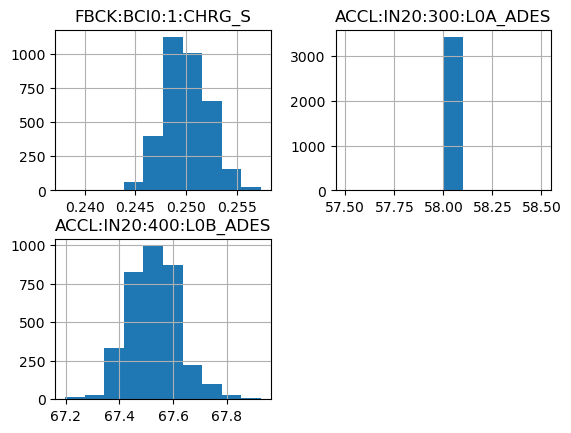

In [83]:
constant_df.hist()
plt.show()

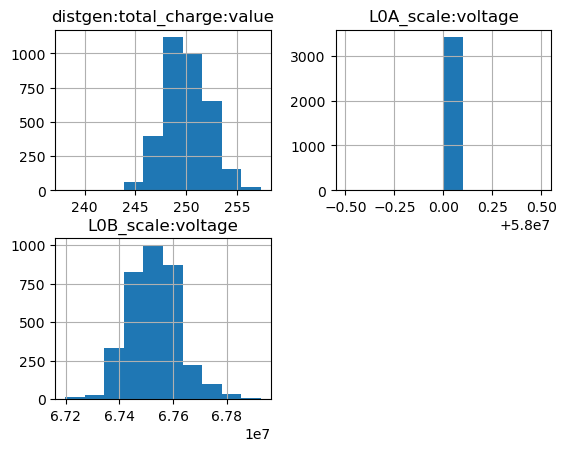

In [85]:
sim_constant_df = pd.DataFrame()

# convert the PV values back to sim values
for sim_name, col_name in zip(constants, constant_df.columns):
    series = constant_df[col_name] * pv_info['pv_to_sim_factor'][col_name]
    sim_constant_df[sim_name] = series
    
sim_constant_df.hist()
plt.show()

In [86]:
sim_constant_df.describe()

,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage
count,3421.000000,3421.0,3.421000e+03
mean,250.004846,58000000.0,6.752801e+07
std,2.164613,0.0,9.481277e+04
min,238.079531,58000000.0,6.719747e+07
25%,248.480256,58000000.0,6.745853e+07
50%,249.943591,58000000.0,6.752396e+07
75%,251.510819,58000000.0,6.758745e+07
max,257.334908,58000000.0,6.792720e+07


## Input Ranges

In [87]:
with open('configs/model_info.json', 'r') as f:
    model_info = json.load(f)
    f.close()

In [88]:
input_features = []
for feature in model_info['model_in_list']:
    # find the pvname for this feature
    pv_name = pv_info['sim_name_to_pv_name'][feature]
    if pv_name not in ['Pulse_length']:
        input_features.append(pv_name.replace('BDES','BCTRL'))

input_features


['IRIS:LR20:130:CONFG_SEL',
 'FBCK:BCI0:1:CHRG_S',
 'SOLN:IN20:121:BCTRL',
 'QUAD:IN20:121:BCTRL',
 'QUAD:IN20:122:BCTRL',
 'ACCL:IN20:300:L0A_ADES',
 'ACCL:IN20:300:L0A_PDES',
 'ACCL:IN20:400:L0B_ADES',
 'ACCL:IN20:400:L0B_PDES',
 'QUAD:IN20:361:BCTRL',
 'QUAD:IN20:371:BCTRL',
 'QUAD:IN20:425:BCTRL',
 'QUAD:IN20:441:BCTRL',
 'QUAD:IN20:511:BCTRL',
 'QUAD:IN20:525:BCTRL']

In [89]:
len(input_features)

15

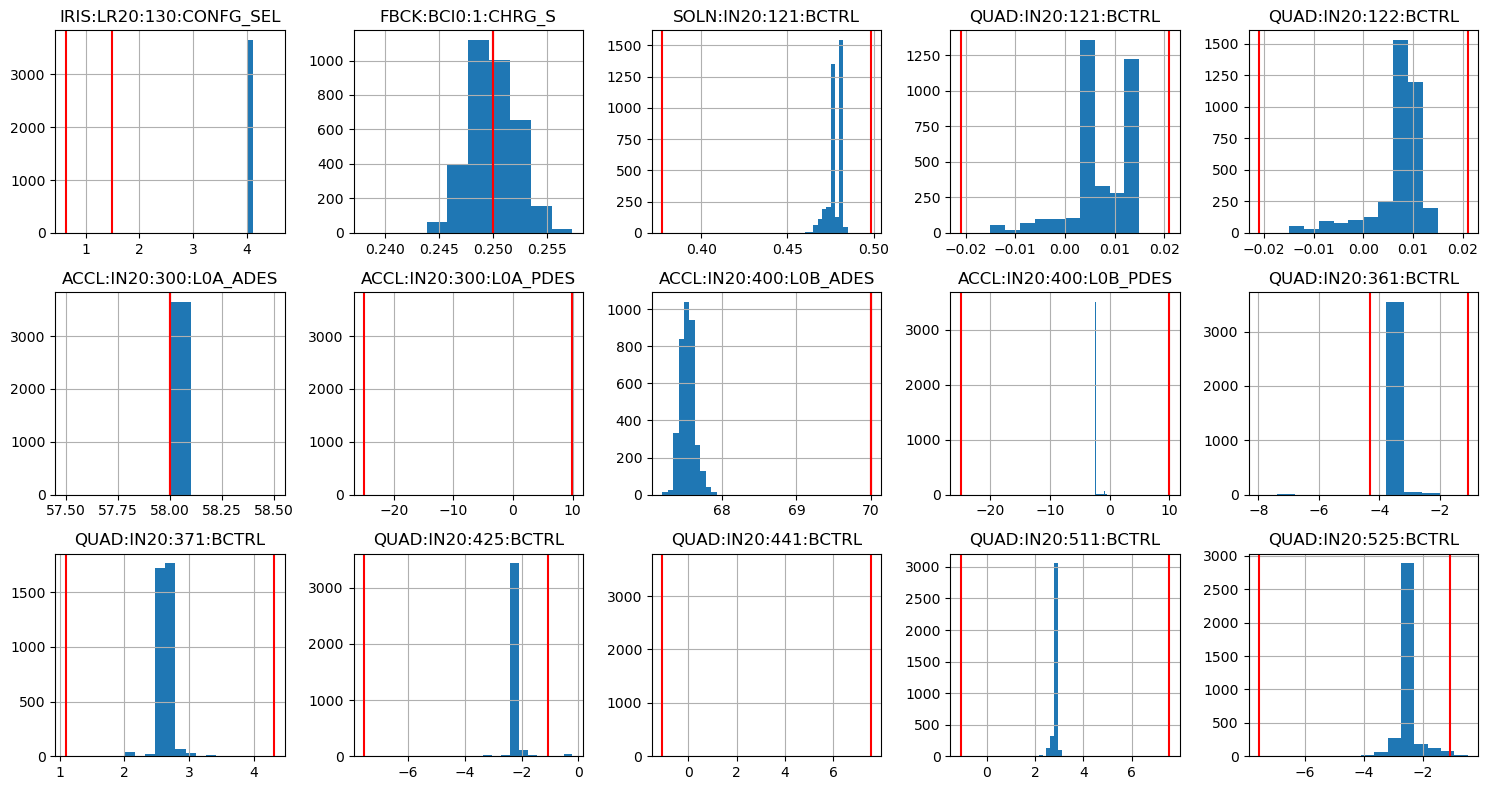

In [90]:
fig, ax = plt.subplots(3,5, figsize=(15,8))
ax = ax.ravel()

for i, input_name in enumerate(input_features):
    # plot the histogram of the real data
    sim_name = pv_info['pv_name_to_sim_name'][input_name.replace('BCTRL', 'BDES')]
    ax[i].set_title(input_name)

    # plot the range that was used during training using the sim to pv conversion
    sim_to_pv_factor = pv_info['sim_to_pv_factor'][sim_name]
    input_loc = model_info['loc_in'][sim_name]
    # print(sim_name, sim_to_pv_factor)
    train_min = model_info['train_input_mins'][input_loc] * sim_to_pv_factor
    train_max = model_info['train_input_maxs'][input_loc] * sim_to_pv_factor

    ax[i].axvline(train_min, c='r')
    ax[i].axvline(train_max, c='r')

    time_series[input_name].hist(ax=ax[i])

fig.tight_layout()
plt.show()

count    3651.000000
mean       -0.017634
std         0.016611
min        -0.179388
25%        -0.016500
50%        -0.016388
75%        -0.015611
max        -0.011535
Name: QUAD:IN20:441:BCTRL, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 3665 entries, 0 to 3664
Series name: QUAD:IN20:441:BCTRL
Non-Null Count  Dtype  
--------------  -----  
3651 non-null   float64
dtypes: float64(1)
memory usage: 28.8 KB
None


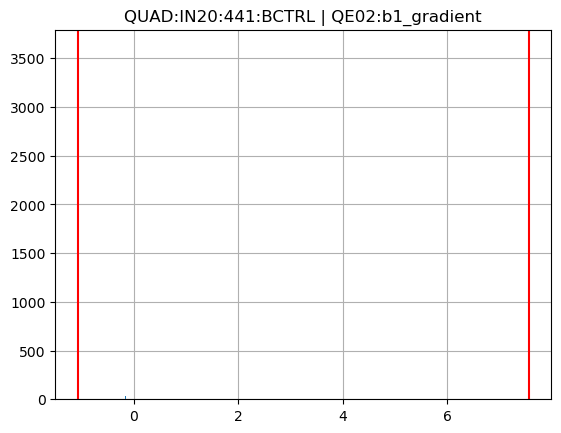

In [93]:
fig, ax = plt.subplots()
# ax = ax.ravel()
input_name = 'QUAD:IN20:441:BCTRL'
print(time_series[input_name].describe())
print(time_series[input_name].info())

# plot the histogram of the real data
sim_name = pv_info['pv_name_to_sim_name'][input_name.replace('BCTRL', 'BDES')]
ax.set_title(f'{input_name} | {sim_name}')

# plot the range that was used during training using the sim to pv conversion
sim_to_pv_factor = pv_info['sim_to_pv_factor'][sim_name]
input_loc = model_info['loc_in'][sim_name]
train_min = model_info['train_input_mins'][input_loc] * sim_to_pv_factor
train_max = model_info['train_input_maxs'][input_loc] * sim_to_pv_factor

ax.axvline(train_min, c='r')
ax.axvline(train_max, c='r')

time_series[input_name].hist(ax=ax)

plt.show()